In [1]:
#import osmnx as ox
import numpy as np
import pandas as pd
import os
#import networkx as nx
from datetime import datetime
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import ast

In [2]:
os.chdir('G:/My Drive/2021/Bias/census_block_data/')

In [3]:
#functions
#os.chdir('G:/My Drive/2021/Bias/census_tract_process/')
def check_missing_routes(est_rt, join_rt):
    num_rt = len(np.unique(est_rt['osmids']))
    num_join_rt = len(np.unique(join_rt['osmids']))
    if num_rt != num_join_rt:
        print(num_rt, num_join_rt, num_rt-num_join_rt)
        #the missing_rt using set is different
        #missing_rt = set(np.unique(est_rt['osmids'])) ^ set(np.unique(join_rt['osmids']))
        return(missing_rt)
    else:
        return(None)
    
def convert_routetype(routes):
    if routes[-1] == ',':
        rt = routes[:-1].strip('[').split(', ')
    else:
        rt = routes.strip('][').split(', ')
    rt = list(rt)
    rt = [int(i) for i in rt]
    return(rt)

#define a function to ensure crossing routes
def get_crossed_ct(osmid, routes_id_dicts, cross_ct_dicts):
    index = routes_id_dicts[osmid]
    census_tract = cross_ct_dicts[index]
    return(index, census_tract)

def add_crossed_ct2dt(dt, index_check_lst, routes_id_dicts, cross_ct_dicts):
    census_t = []
    osmids = list(dt['osmids'].values)
    for osmid in osmids:
        index, ct = get_crossed_ct(osmid, routes_id_dicts, cross_ct_dicts)
        if index not in index_check_lst:
            index_check_lst.append(index)
        census_t.append(ct)
    dt['crossed_ct'] = census_t
    return(index_check_lst)

#the points are remapped after the shortest path algorithm
#thus, in this case, we will use the remapped origin and destinated ct to ensure it also matches the crossed route results
def find_ct(rt, missing_node, origin=True):
    ori = 0
    if origin==True:
        for i in range(len(rt)):
            if rt[i] in node_in_ct:
                ori = node_in_ct[rt[i]]
                break
    else:
        dest_index = -1
        for i in range(len(rt)):
            if rt[(-1-i)] in node_in_ct:
                ori = node_in_ct[rt[(-1-i)]]
                break
    if ori == 0:
        for osmid in rt:
            if osmid not in missing_node:
                missing_node.append(osmid)
    return(ori, missing_node)

def get_newod(osmid, missed_node):
    rt = convert_routetype(osmid)
    ori, missed_node = find_ct(rt, missed_node, True)
    dest, missed_node = find_ct(rt, missed_node, False)
    return(ori, dest, missed_node)

def find_ctfromosmid(osmids):
    route = convert_routetype(osmids)
    crossed_ct = []
    for i in route:
        if i in node_in_ct:
            if node_in_ct[i] not in crossed_ct:
                crossed_ct.append(node_in_ct[i])
    return(crossed_ct)

#G_nodeswithct = pd.read_csv('G:/My Drive/2021/Bias/census_tract_process/nodes_in_cts.csv')
#input_path = 'G:/My Drive/2021/Bias/census_tract_process/nodes_in_cts.csv', geoid_col ='GEOID10'
def get_node_info(input_path, geoid_col, ct_index = False):
    G_nodeswithct = pd.read_csv(input_path)
    #print(G_nodeswithct.head(3))
    #print(np.unique(G_nodeswithct['GEOID10']))
    #print(np.unique(G_nodeswithct[geoid_col]))

    #get points to census tract dict
    osmids = list(G_nodeswithct['osmid'].values)
    #geoids = list(G_nodeswithct['GEOID10'].values)
    geoids = list(G_nodeswithct[geoid_col].values)

    node_in_ct = {}
    for i in range(len(osmids)):
        if np.isnan(geoids[i]) == False:
            node_in_ct[osmids[i]] = int(geoids[i])

    #manual add some of the feature to census tract
    #if ct_index == True:
    #    node_in_ct[53214121] = 53033007402
    #    node_in_ct[53129446] = 53033007401
    #    node_in_ct[53073260] = 53033007402
        
    return(G_nodeswithct, node_in_ct)

#get nearest node

#post data processing
#made zero matrix 
#Functions
#for the ods at the same location
#the other location at the same time should be 0
#time_diff <= 10 min

#for the ods at different location
#the other location which not belongs to the route or neatby od should be 0
#time_diff <= 20 min

#get 0 value

#besides,if appears in one place already, the location will not appear in the other census tract
def extract_od(dt, sameod = True):
    if sameod == True:
        test_dt = dt[(dt['od_euqal']==1) & (dt['time_diff']<=10)]
    else:
        test_dt = dt[(dt['od_euqal']==0) & (dt['time_diff']<=20)]
    return(test_dt)

def convert2stid(hr, minut_5, census):
    return(str(census)+'_'+str(hr)+'_'+str(minut_5))

def process_dt4convert(shr, ehr, smin, emin):
    if ehr-shr<0:
        print('data error')
        return(None)
    if ehr-shr == 0:
        if emin-smin == 0:
            return([shr], [smin])
        elif emin-smin <0:
            print('data error')
            return(None)
        else:
            interval = int((emin-smin)/5)
            min_lst = [smin]
            hr_lst = [shr]
            if interval > 1:
                for i in range(interval):
                    min_lst.append(int(smin+5*(i+1)))
                    hr_lst.append(shr)
            else:
                min_lst.append(emin)
                hr_lst.append(shr)
            return(hr_lst, min_lst)
    else:
        if emin+60-smin == 0:
            return([shr], [smin]) 
        else:
            interval = int((emin+60-smin)/5)    
            hr_lst = [shr]
            min_lst = [smin]
            if interval > 1:
                for i in range(interval):
                    if smin+(i+1)*5 >= 60:
                        min_lst.append(smin+(i+1)*5-60)
                        hr_lst.append(ehr)
                    else:
                        min_lst.append(smin+(i+1)*5)
                        hr_lst.append(shr)
            else:             
                min_lst.append(emin)
                hr_lst.append(ehr)
            return(hr_lst, min_lst) 
        
def add_zero_loc(shr, ehr, s5min, e5min, nocrossedcts, zero_loclst):
    for i in range(len(shr)):
        hr, minut = process_dt4convert(shr[i], ehr[i], s5min[i], e5min[i])
        for j in nocrossedcts[i]:
            for k in range(len(hr)):
                loc_timeids = convert2stid(hr[k], minut[k], j)
                if loc_timeids not in zero_loclst:
                    zero_loclst.append(loc_timeids)
    return(zero_loclst)

def get_nocrossed_stids(dt, zero_loc_time):
    dt = dt.sort_values(by=['newid'])
    newids = np.unique(dt['newid'])
    
    for ids in newids:
        if ids not in zero_loc_time:
            zero_loc_time[ids] = []
        #get start and end hr
        s_hr = list(dt['s_hr'][dt['newid']==ids].values)
        e_hr = list(dt['e_hr'][dt['newid']==ids].values)
        s_5min = list(dt['s_minut_5'][dt['newid']==ids].values)
        e_5min = list(dt['e_minut_5'][dt['newid']==ids].values)
        no_crossed_cts = list(dt['no_crossedcts'][dt['newid']==ids].values)
        
        zero_loc_time[ids] = add_zero_loc(s_hr, e_hr, s_5min, e_5min, no_crossed_cts, zero_loc_time[ids])
    return(zero_loc_time)

def getzero_info(dt):
    zero_loc_time = {}
    dt1 = extract_od(dt, sameod = True)
    dt2 = extract_od(dt, sameod = False)
    zero_loc_time = get_nocrossed_stids(dt1, zero_loc_time)
    zero_loc_time = get_nocrossed_stids(dt2, zero_loc_time)
    return(zero_loc_time)

def get_revised_matrix(pred_matrix, zero_loc_time):
    for ids in zero_loc_time:
        for loct_time in zero_loc_time[ids]:
            pred_matrix[newids_map[ids]][locts_map[loct_time]] = 0
    return(pred_matrix)

def convert_missingids(time_lst, ids, time_spatial_ids, Seattle_latlon, geoid_col):
    for t in time_lst:
        hr = (Seattle_latlon['hr'][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        minut = (Seattle_latlon['minut_5'][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        geoid = (Seattle_latlon[geoid_col][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        newgeo = (Seattle_latlon['new_geos'][(Seattle_latlon['newid']==ids) & (Seattle_latlon['timestamp']==t)]).values[0]
        geos = list(np.unique([geoid, newgeo]))
        if 0 in geos:
            geos.remove(0)
        #get no observed census_t
        diff_ct = list(set(census_t) ^ set(geos))
        for geoid in diff_ct:
            time_spatial_id = convert2stid(hr, minut, geoid)
            if time_spatial_id not in time_spatial_ids:
                time_spatial_ids.append(time_spatial_id)
    return(time_spatial_ids)

latlon_path = 'G:/My Drive/2021/Bias/census_tract_process/'
Seattle_latlon = pd.read_csv(latlon_path+'Seattle_latlon.csv', index_col=0)

#convert data with estimated shortest path info
#file_path = 'G:/My Drive/2021/Bias/census_tract_process/crossed_routes.csv'
#crossed_rt = pd.read_csv(file_path)
def process_crossed_file(crossed_rt):
    get_hr = lambda x: datetime.fromtimestamp(x).hour
    get_minute = lambda x: datetime.fromtimestamp(x).minute
    crossed_rt['s_hr'] = crossed_rt['start_time'].apply(get_hr).values
    crossed_rt['e_hr'] = crossed_rt['end_time'].apply(get_hr).values
    crossed_rt['s_min'] = crossed_rt['start_time'].apply(get_minute).values
    crossed_rt['e_min'] = crossed_rt['end_time'].apply(get_minute).values

    to5min = lambda x: int(x/5)*5
    crossed_rt['s_minut_5'] = crossed_rt['s_min'].apply(to5min)
    crossed_rt['e_minut_5'] = crossed_rt['e_min'].apply(to5min)

    get_timeloct_id = lambda x: str(x)+'_'
    remove_last_symbol = lambda x: x[:-1]
    crossed_rt['ori_st'] = (crossed_rt['new_ori'].apply(get_timeloct_id)+\
    crossed_rt['s_hr'].apply(get_timeloct_id)+\
    crossed_rt['s_minut_5'].apply(get_timeloct_id)).apply(remove_last_symbol)

    crossed_rt['dest_st'] = (crossed_rt['new_dest'].apply(get_timeloct_id)+\
    crossed_rt['e_hr'].apply(get_timeloct_id)+\
    crossed_rt['e_minut_5'].apply(get_timeloct_id)).apply(remove_last_symbol)

    return(crossed_rt)
def get_short_path(origin, destination, tt=False, plot_route=False):
    routes_not_found = []
    ori_y, ori_x = origin
    dest_y, dest_x = destination
    ori = ox.distance.nearest_nodes(G, ori_x, ori_y)
    dest = ox.distance.nearest_nodes(G, dest_x, dest_y)
    try:
        if tt == True:
            route = nx.shortest_path(G, ori, dest, weight='travel time')
            travel_time = nx.shortest_path_length(G, ori, dest, weight='travel time')
        else:
            route = nx.shortest_path(G, ori, dest)
            travel_time = nx.shortest_path_length(G, ori, dest, weight='travel time')

        route_nodes = nodes_proj.loc[route]
        route_nodes = route_nodes.reset_index()

        if len(route_nodes['osmid']) > 1:
            route_line = LineString(list(route_nodes.geometry.values))
            route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

            # Add a list of osmids associated with the route
            route_geom.loc[0, 'osmids'] = str(list(route_nodes['osmid'].values))
            route_geom['length_m'] = route_geom.length
            route_geom['travel_time'] = travel_time
            if plot_route == True:
                fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')
            return(route_geom)
        else:
            return(1)
    except:
        routes_not_found.append(ori)
        routes_not_found.append(destination)
        return(0)
    
#extract lat lon info from dataframe
def extract_info(latlon_file, geoid_col, newids):
    latlon_dict = {}
    latlon_geoid = {}
    start_end_time = {}
    for ids in newids:
        latlon_dict[ids] = latlon_file[['lat','lon']][latlon_file['newid']==ids].values
        latlon_geoid[ids] = latlon_file[[geoid_col]][latlon_file['newid']==ids].values
        start_end_time[ids] = latlon_file['timestamp'][latlon_file['newid']==ids].values
    
    return(latlon_dict, latlon_geoid, start_end_time)

#change kernels
#conver kernel to Python 3
#os.chdir('G:/My Drive/2021/Bias/census_tract_process/')
#os.chdir('G:/My Drive/2021/Bias/census_block_data/')

#os.listdir

def spatial_join(zone_path, points):
    Zone = gpd.read_file(zone_path)
    Zone.crs = points.crs
    points = gpd.tools.sjoin(points, Zone, how='left')
    return(points)

#check shortest path
def route_plot(route_data):
    fig, ax = ox.plot_graph_route(G, route_data, route_linewidth=6, node_size=0, bgcolor='k')

def convert_routetype(routes):
    rt = routes.strip('][').split(', ')
    rt = list(rt)
    rt = [int(i) for i in rt]
    return(rt)

def plot_based_on_id(newids):
    test_routes = shortest_routes[shortest_routes['newid']==newids]
    route_info = test_routes['osmids'].values
    for routes in route_info:
        rt = convert_routetype(routes)
        print(rt)
        route_plot(rt)
        
#get time different
def timestamp2date(x):
    datex = datetime.fromtimestamp(x)
    return(datex)

#get time difference (in minutes)
def gettimediff(start, end):
    #convert timestamp to date
    start_d = timestamp2date(start)
    end_d = timestamp2date(end)
    #print(start_d, end_d)
    duration = (end_d-start_d).total_seconds()
    minutes_diff = divmod(duration, 60)[0]
    return(minutes_diff)

#latlon_file.sort_values(by=['accuracy'], ascending=False)

#Zone = gpd.read_file(Seattle_ct_path)
#route_file = spatial_join(Seattle_ct_path, route_file)
#route_file.columns

#shortest_routes = gpd.read_file('../estimated_routes.shp')

#test_ids = latlon_file[latlon_file['newid']==32]
#test_ids.to_csv('latlon_id32.csv')


### sparse svd
#predsvd_rmse_s, lfsvd_rmse_s, rmse_svd_s = get_best_svd(test_matrice_scaled_reverse, False)
#predsvd_rmse, lfsvd_rmse, rmse_svd = get_best_svd(test_matrice_reverse, False)

#nmf_rmse_dict, nmf_zero_score, nmf_mae_dict, nmf_rmse_w0, nmf_mae_w0 = get_best_NMFwzero(test_matrice_reverse, Zero_index)

def read_dict(filepath):
    with open(filepath) as f:
        data = f.read()
    dict_data = ast.literal_eval(data)
    return(dict_data)

def convert_dict(index_dict):
    convertdict = {}
    for keys in index_dict:
        convertdict[index_dict[keys]] = keys
    return(convertdict)

In [4]:
#os.listdir('G:/My Drive/2021/Bias/census_tract_process/')
node_path = 'G:/My Drive/2021/Bias/census_tract_process/'
#os.listdir(node_path)

In [9]:
#pd.read_csv(node_path+'nodes_in_taz_cts.csv').columns

Index(['osmid', 'y', 'x', 'street_cou', 'highway', 'ref', 'GEOID10',
       'INTPTLAT10', 'INTPTLON10', 'NUMPOINTS', 'Area', 'Distance m',
       'Distance_1', 'geometry', 'sum', 'pop', 'home_ratio', 'Count_',
       'Nb_interse', 'nb_touch', 'nb_bf1mi', 'TAZ', 'COUNTY_FIP', 'COUNTY_NM'],
      dtype='object')

In [ ]:
latlon_file = pd.read_csv('G:/My Drive/2021/Bias/census_tract_process/Seattle_latlon.csv', index_col=0)
latlon_file.sort_values(by=['newid', 'timestamp'])
newids= np.unique(latlon_file.newid)

In [10]:
latlon_file.columns

Index(['index', 'Unnamed: 0.1', 'timestamp', 'lat', 'lon', 'accuracy',
       'idtype', 'newid', 'd', 'hr', 'minut', 'obs', 'time', 'geometry',
       'index_right', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10',
       'NAME10', 'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'geoid', 'new_geos'],
      dtype='object')

In [11]:
latlon_dict, latlon_geoid, start_end_time = extract_info(latlon_file, 'GEOID10', newids)

In [12]:
os.chdir('G:/My Drive/2021/Bias')

In [13]:
#G_nodeswithct, node_in_ct = get_node_info('G:/My Drive/2021/Bias/census_tract_process/nodes_in_cts.csv', 'GEOID10', True)
G_nodeswithct, node_in_ct = get_node_info('G:/My Drive/2021/Bias/census_tract_process/nodes_in_taz_cts.csv', 'TAZ', True)

taz_path = 'G:/My Drive/2021/Bias/SUMO_simulation/'
route_file_taz = pd.read_csv(taz_path+'route_fileTAZ04042017.csv', index_col=0)
route_file_taz.columns

route_file = pd.read_csv(node_path+'crossed_routes.csv', index_col=0)
print(route_file.columns)
print(route_file.head(3))
#os.listdir(taz_path)
#for land use data
#previous code
#G_nodeswithct, node_in_ct = get_node_info('G:/My Drive/2021/Bias/census_tract_process/nodes_in_cts.csv', 'GEOID10', True) 
#G_nodeswithct, node_in_ct = get_node_info('G:/My Drive/2021/Bias/census_block_data/nodes_in_land_use.csv', 'ZONEID')

 
#for i in os.listdir(node_path):
#    if 'route' in i:
#        print(i)

Index(['Unnamed: 0.1', 'geometry', 'osmids', 'length_m', 'newid', 'ori_geo',
       'dest_geo', 'start_time', 'end_time', 'time_diff', 'od_euqal',
       'new_ori', 'new_dest', 'crossed_ct', 'ct_check', 'no_crossed_ct',
       'travel_time'],
      dtype='object')
       Unnamed: 0.1                                           geometry  \
34409             0  LINESTRING (-122.3353207 47.6070445, -122.3359...   
34410             1  LINESTRING (-122.3385429 47.6121913, -122.3374...   
34411             2  LINESTRING (-122.3374036 47.6126719, -122.3364...   

                                                  osmids  length_m  newid  \
34409  [53200376, 53213413, 53213414, 53205953, 53142...  0.007554     32   
34410                           [2481926130, 3618304999]  0.001237     32   
34411       [3618304999, 53213824, 53213823, 2481926130]  0.003964     32   

           ori_geo     dest_geo  start_time    end_time  time_diff  od_euqal  \
34409  53033008100  53033008100  1491399907  1491

In [18]:
#create row index and column index
max(route_file['time_diff'])

1374.0

In [15]:
#join routes to census tract
def tide_route_file(route_file, savefile=False):
    uniq_routes = list(np.unique(route_file['osmids'].values))

    routes_id_dicts = {}
    cross_ct_dicts = {}
    for index in range(len(uniq_routes)):
        #print(index)
        routes_id_dicts[uniq_routes[index]] = index
        cross_ct_dicts[index] = find_ctfromosmid(uniq_routes[index])

    new_ori = []
    new_dest = []
    missed_node = []

    for route in route_file['osmids'].values:
        newo, newd, missed_node = get_newod(route, missed_node)
        new_ori.append(newo)
        new_dest.append(newd)

    route_file['new_ori'] = new_ori
    route_file['new_dest'] = new_dest
    
    #separate od types
    #assign an index
    route_file['od_euqal'] = list((route_file['new_ori'] == route_file['new_dest']).values)
    #for the same od, check if the shortest path will cross the similar ods
    #to correct the current od matrice, we will need to know the origin, destination
    #and crossed time period
    #ods with same o and same d
    route_wsameod = route_file[route_file['od_euqal']==True]
    route_wosameod = route_file[route_file['od_euqal']==False]

    print('num data with same od',len(route_wsameod['od_euqal']))
    print('num data without same od',len(route_wosameod['od_euqal']))
    print('percentage of same od',len(route_wsameod['od_euqal'])/len(route_file['od_euqal']))
    index_check_lst = []
    index_check_lst = add_crossed_ct2dt(route_wsameod, index_check_lst, routes_id_dicts, cross_ct_dicts)
    index_check_lst = add_crossed_ct2dt(route_wosameod, index_check_lst, routes_id_dicts, cross_ct_dicts)

    #for od within the same census tract,
    #check if there are other crossed ct
    ct_check = lambda x: 0 if (len(x) > 2) else 1
    route_wsameod['ct_check'] = route_wsameod['crossed_ct'].apply(ct_check).values

    #ct_check = lambda x: 0 if (len(x) > 3) else 1
    #route_wosameod['ct_check'] = route_wosameod['crossed_ct'].apply(ct_check).values
    #route_wosameod.head(3)

    #route_wosameod[route_wosameod['ct_check']==0].head(10)
    route_wosameod['ct_check'] = 2

    #identify census tract not in the crossed ct
    geoids = list(np.unique(route_wosameod['new_ori']))
    get_nocrossed_ct = lambda x: list(set(x)^set(geoids))
    route_wosameod['no_crossed_ct'] = route_wosameod['crossed_ct'].apply(get_nocrossed_ct).values
    route_wsameod['no_crossed_ct'] = route_wsameod['crossed_ct'].apply(get_nocrossed_ct).values
    
    cross_file = pd.concat([route_wsameod, route_wosameod])
    
    #convert to csv
    if savefile == True:
        cross_file.to_csv('crossed_routes.csv')
    
    return(cross_file)

In [116]:
cross_file_taz = tide_route_file(route_file_taz)

num data with same od 14218
num data without same od 50679
percentage of same od 0.21908562799513073


C:\Users\29700\AppData\Local\Temp\ipykernel_10300\1822330498.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['crossed_ct'] = census_t
C:\Users\29700\AppData\Local\Temp\ipykernel_10300\3808455572.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_wsameod['ct_check'] = route_wsameod['crossed_ct'].apply(ct_check).values
C:\Users\29700\AppData\Local\Temp\ipykernel_10300\3808455572.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [117]:
crossed_rt = process_crossed_file(cross_file_taz)

In [118]:
crossed_rt.columns

Index(['geometry', 'osmids', 'length_m', 'newid', 'ori_geo', 'dest_geo',
       'start_time', 'end_time', 'time_diff', 'new_ori', 'new_dest',
       'od_euqal', 'crossed_ct', 'ct_check', 'no_crossed_ct', 's_hr', 'e_hr',
       's_min', 'e_min', 's_minut_5', 'e_minut_5', 'ori_st', 'dest_st'],
      dtype='object')

In [122]:
#crossed_rt = crossed_rt[crossed_rt.columns[5:]]
#crossed_rt.columns
#get row and column index
row_index = read_dict('row_index.txt')
col_index = read_dict('col_index.txt')

user_index = convert_dict(row_index)
item_index = convert_dict(col_index)

In [ ]:
print(len(user_index), len(item_index))

In [155]:
row_path = 'G:/My Drive/2021/Bias/SUMO_simulation/newid_tsid_aggregation.txt'
row_index = []
with open(row_path, 'r') as f:
    row_index.append(f.readlines())

In [163]:
row_path = 'G:/My Drive/2021/Bias/SUMO_simulation/newid_tsid_aggregation.txt'
newidst_index = []
with open(row_path, 'r') as f:
    newidst_index.append(f.readlines())
    
row_index = ast.literal_eval('{'+newidst_index[0][0].split('{')[1])
geoid_col_index = ast.literal_eval('{'+newidst_index[0][0].split('{')[2])
del(newidst_index)

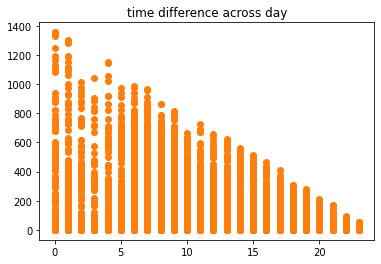

In [58]:
#crossed_rt.to_csv('crossed_rt.csv')

#check time difference change for each individual
#this part needs to be processed in the algorithm code(either in NMF/AE)

newids_map = row_index
newids = list(newids_map.keys())
a = 0
index = 0
for ids in newids:
    if a <= index:
        test_dt = crossed_rt[['time_diff', 's_hr','e_hr','od_euqal']][crossed_rt['newid'] == ids]
        test_dt = test_dt.sort_values(by=['time_diff'])
        plt.figure(a)
        x = list(test_dt['s_hr'].values)
        y = list(test_dt['time_diff'].values)
        plt.plot(x,y,'o')
        plt.title('time difference between each time segement for ids = '+str(ids))
        a += 1
        
test_dt = crossed_rt[['s_hr', 'time_diff']][crossed_rt['od_euqal']==0].sort_values(by=['s_hr', 'time_diff'])
#plot time difference across day
#plt.figure(0)
#plt.plot(list(test_dt['s_hr'].values), list(test_dt['time_diff'].values),'o')
#plt.title('time difference across day')

#keep previous census tract
ori_geo = crossed_rt['ori_geo'].values
dest_geo = crossed_rt['dest_geo'].values
no_crossed_ct = crossed_rt['no_crossed_ct'].values

In [63]:
no_crossed_cts = []
for i in range(len(ori_geo)):
    no_crossed = no_crossed_ct[i]
    if str(ori_geo[i]) in no_crossed:
        no_crossed.remove(str(ori_geo[i]))
    if str(dest_geo[i]) in no_crossed:
        no_crossed.remove(str(dest_geo[i]))
    no_crossed_cts.append(no_crossed)
    

In [51]:
#no_crossed_ct

In [86]:
latlon_file = pd.read_csv(taz_path+'laltontaz04042017.csv', index_col=0)
geoid_col = 'TAZ'

#we found missing valeues after we processing the data
#latlon_path = 'G:/My Drive/2021/Bias/data-processing/'
#Seattle_latlon = pd.read_csv('Seattle_latlon.csv', index_col=0)

selected_colname = list(latlon_file.columns)
#selected_colname.remove('Unnamed: 0.1')

to5min = lambda x: int(x/5)*5
latlon_file['minut_5'] = (latlon_file['minut'].apply(to5min)).values
#through the checking, it is found there are individuals missing after the shortest path algorithm
ids_in_dt = list(np.unique(crossed_rt['newid']))
diff = set(newids)^set(ids_in_dt)

print('# of ids with shortest path: ', len(ids_in_dt))
print('# of identified ids: ', len(newids_map.keys()))
print('# of missing ids without shortest path: ', len(diff))

crossed_rt['no_crossedcts'] = no_crossed_cts
crossed_rt = crossed_rt.sort_values(by=['newid','time_diff','s_hr'])

#check the missed data in detail

crossed_rt = crossed_rt.sort_values(by=['newid','start_time'])
crossed_rt.reset_index(inplace=True)
crossed_rt.head(3)

newids = np.unique(crossed_rt['newid'])
kept_data_start = {}
kept_data_end = {}
for ids in newids:
    kept_data_start[ids] = list(crossed_rt['start_time'][crossed_rt['newid']==ids].values)
    kept_data_end[ids] = list(crossed_rt['end_time'][crossed_rt['newid']==ids].values)
    
#get missing trips
#missing ids with missing data
newids = np.unique(crossed_rt['newid'])
newids_all = list(newids_map.keys())
missing_ids = {}
for ids in newids_all:
    missing_ids[ids] = []
    time_data = list(latlon_file['timestamp'][latlon_file['newid']==ids].values)
    if ids not in newids:
        missing_ids[ids] = time_data
    else:    
        for time in time_data:
            if time not in kept_data_end[ids] and time not in kept_data_start[ids]:
                missing_ids[ids].append(time)
                
missing_pairs = {}
for ids in newids:
    missing_pairs[ids] = {'o':[],'d':[]}
    cur_odpairs = crossed_rt[['start_time', 'end_time']][crossed_rt['newid']==ids].values
    time_data = list(latlon_file['timestamp'][latlon_file['newid']==ids].values)
    for i in range(len(time_data)):
        if i < len(time_data)-1:
            od_pairs = []
            od_pairs.append(time_data[i]) 
            od_pairs.append(time_data[i+1])
            if od_pairs not in cur_odpairs:
                missing_pairs[ids]['o'].append(od_pairs[0])
                missing_pairs[ids]['d'].append(od_pairs[1]) 
                
                
print('worst data accuracy: ', np.max(latlon_file['accuracy']))

# of ids with shortest path:  6903
# of identified ids:  8230
# of missing ids without shortest path:  0


In [94]:
census_t = list(np.unique(latlon_file[geoid_col]))

zero_loc_time = {}
for ids in missing_ids:
    if ids not in zero_loc_time:
        zero_loc_time[ids] = []
    zero_loc_time[ids] = convert_missingids(missing_ids[ids], ids, zero_loc_time[ids], latlon_file, 'TAZ')
    
# create the zero index matrix
matrix_shapes = (len(newids), len(np.unique())
Zero_index = np.zeros(test_matrice_reverse[:, 1:].shape)
for row in zero_loc_time:
    for col in zero_loc_time[row]:
        Zero_index[newids_map[row]][locts_map[col]] = 1

KeyError: 'new_geos'

In [ ]:
#previous data process for census tract
'''
#get neighborhood census tract info
os.chdir('G:/My Drive/2021/Bias/census_tract_process')
pathfiale = 'G:/My Drive/2021/Bias/census_tract_process/'
Seattle_ct = pd.read_csv(pathfile+'Seattle_ct.csv')
Seattle_ct.columns
Seattle_ct = Seattle_ct[['GEOID10','Nb_interse', 'nb_count', 'nb_touch', 'nb_bf_5', 'nb_bf10', \
                         'nb_bf100','nb_bf1mi','Area', 'Distance m','Distance_1', 'field_1', 'index']]

#check time difference change for each individual
newids_map = row_index
newids = list(newids_map.keys())
a = 0
index = 0
for ids in newids:
    if a <= index:
        test_dt = crossed_rt[['time_diff', 'travel_time','s_hr','e_hr','od_euqal']][crossed_rt['newid'] == ids]
        test_dt = test_dt.sort_values(by=['time_diff'])
        plt.figure(a)
        x = list(test_dt['s_hr'].values)
        y = list(test_dt['time_diff'].values)
        plt.plot(x,y,'o')
        plt.title('time difference between each time segement for ids = '+str(ids))
        a += 1
        
test_dt = crossed_rt[['s_hr', 'time_diff', 'travel_time']][crossed_rt['od_euqal']==0].sort_values(by=['s_hr', 'time_diff'])
plt.figure(0)
plt.plot(list(test_dt['s_hr'].values), list(test_dt['time_diff'].values),'o')
plt.title('time difference across day')
plt.figure(1)
plt.plot(list(test_dt['s_hr'].values), list(test_dt['travel_time'].values),'ro')
plt.title('travel time across day (estimated based on shortest path)')

#keep previous census tract
ori_geo = crossed_rt['ori_geo'].values
dest_geo = crossed_rt['dest_geo'].values
no_crossed_ct = crossed_rt['no_crossed_ct'].values
no_crossed_cts = []
for i in range(len(ori_geo)):
    no_crossed = no_crossed_ct[i].strip('[]').split(', ')
    if str(ori_geo[i]) in no_crossed:
        no_crossed.remove(str(ori_geo[i]))
    if str(dest_geo[i]) in no_crossed:
        no_crossed.remove(str(dest_geo[i]))
    no_crossed_cts.append(no_crossed)

del(ori_geo)
del(dest_geo)
del(no_crossed_ct)

crossed_rt['no_crossedcts'] = no_crossed_cts
crossed_rt = crossed_rt.sort_values(by=['newid','time_diff','s_hr'])


#we found missing valeues after we processing the data
#latlon_path = 'G:/My Drive/2021/Bias/data-processing/'
Seattle_latlon = pd.read_csv('Seattle_latlon.csv', index_col=0)

selected_colname = list(Seattle_latlon.columns)
selected_colname.remove('Unnamed: 0.1')
Seattle_latlon = Seattle_latlon[selected_colname]
Seattle_latlon['minut_5'] = (Seattle_latlon['minut'].apply(to5min)).values
#through the checking, it is found there are individuals missing after the shortest path algorithm
ids_in_dt = list(np.unique(crossed_rt['newid']))
diff = set(newids)^set(ids_in_dt)

print('# of ids with shortest path: ', len(ids_in_dt))
print('# of identified ids: ', len(newids_map.keys()))
print('# of missing ids without shortest path: ', len(diff))

#check the missed data in detail

crossed_rt = crossed_rt.sort_values(by=['newid','start_time'])
crossed_rt.reset_index(inplace=True)
crossed_rt.head(3)

newids = np.unique(crossed_rt['newid'])
kept_data_start = {}
kept_data_end = {}
for ids in newids:
    kept_data_start[ids] = list(crossed_rt['start_time'][crossed_rt['newid']==ids].values)
    kept_data_end[ids] = list(crossed_rt['end_time'][crossed_rt['newid']==ids].values)
    
#get missing trips
#missing ids with missing data
newids = np.unique(crossed_rt['newid'])
newids_all = list(newids_map.keys())
missing_ids = {}
for ids in newids_all:
    missing_ids[ids] = []
    time_data = list(Seattle_latlon['timestamp'][Seattle_latlon['newid']==ids].values)
    if ids not in newids:
        missing_ids[ids] = time_data
    else:    
        for time in time_data:
            if time not in kept_data_end[ids] and time not in kept_data_start[ids]:
                missing_ids[ids].append(time)
                
missing_pairs = {}
for ids in newids:
    missing_pairs[ids] = {'o':[],'d':[]}
    cur_odpairs = crossed_rt[['start_time', 'end_time']][crossed_rt['newid']==ids].values
    time_data = list(Seattle_latlon['timestamp'][Seattle_latlon['newid']==ids].values)
    for i in range(len(time_data)):
        if i < len(time_data)-1:
            od_pairs = []
            od_pairs.append(time_data[i]) 
            od_pairs.append(time_data[i+1])
            if od_pairs not in cur_odpairs:
                missing_pairs[ids]['o'].append(od_pairs[0])
                missing_pairs[ids]['d'].append(od_pairs[1]) 
                
                
print('worst data accuracy: ', np.max(Seattle_latlon['accuracy']))

census_t = list(np.unique(Seattle_latlon['GEOID10']))

zero_loc_time = {}
for ids in missing_ids:
    if ids not in zero_loc_time:
        zero_loc_time[ids] = []
    zero_loc_time[ids] = convert_missingids(missing_ids[ids], ids, zero_loc_time[ids])
    
# create the zero index matrix
Zero_index = np.zeros(test_matrice_reverse[:, 1:].shape)
for row in zero_loc_time:
    for col in zero_loc_time[row]:
        Zero_index[newids_map[row]][locts_map[col]] = 1'''

In [ ]:
'''
#previous code for directly route join
#there will be route info missings
cross_routes = pd.read_csv('crossed_routes.csv')
cross_routes.head(3)

#process the nan values
geoid = []
for i in cross_routes['GEOID10'].values:
    if np.isnan(i)==True:
        geoid.append(0)
    else:
        geoid.append(int(i))
        
missing_rt = check_missing_routes(route_file, cross_routes)
missing_routes = []
for routes in missing_rt:
    rt = convert_routetype(routes)
    missing_routes.append(rt)

#del(missing_rt)

est_rt = np.unique(route_file['osmids'])
join_rt = np.unique(cross_routes['osmids'])
a = 0
missed_index = []
for i in range(len(join_rt)):
    if join_rt[i] not in est_rt:
        missed_index.append(i)
        a += 1

missing_details = np.unique(missing_routes)

#plot missing details
for i in missing_routes:
    if a <= 15:
        print(i)
        route_plot(convert_routetype(i))
        a += 1

cross_routes['geoid'] = geoid

#check routes
i = 0 
for rt_no_geo in cross_routes['osmids'][cross_routes['geoid']==0].values:
    if i <= 10:
        rt = convert_routetype(rt_no_geo)
        route_plot(rt)
        i +=1

#replace the nan value based on the plot checking
geoid = []
for i in cross_routes['GEOID10'].values:
    if np.isnan(i)==True:
        geoid.append(53033007402)
    else:
        geoid.append(int(i))

cross_routes['geoid'] = geoid

cross_routes = cross_routes.sort_values(by=['index'])
cross_routes = cross_routes.reset_index(inplace=True)'''